<a href="https://colab.research.google.com/github/helenamartinez/UFMS/blob/main/RL_A%C3%A7%C3%B5es_AMZN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

# 1. Carregar o arquivo
df = pd.read_csv("Amazon_historical_data.csv")

# 2. Conversão e Indexação
# O fuso horário (ex: -04:00) deve ser removido ou tratado.
# Usamos 'utc=True' e depois definimos a data como índice.
df['Date'] = pd.to_datetime(df['Date'], utc=True)
df = df.set_index('Date')

# 3. Limpeza simples
# Remove colunas que não variam ou não são necessárias para o modelo de previsão
df = df.drop(columns=['ticker', 'name'])

# Verifique o resultado
print(df.head())
print(df.info())

                               Open      High       Low     Close      Volume
Date                                                                         
1997-05-15 04:00:00+00:00  0.121875  0.125000  0.096354  0.097917  1443120000
1997-05-16 04:00:00+00:00  0.098438  0.098958  0.085417  0.086458   294000000
1997-05-19 04:00:00+00:00  0.088021  0.088542  0.081250  0.085417   122136000
1997-05-20 04:00:00+00:00  0.086458  0.087500  0.081771  0.081771   109344000
1997-05-21 04:00:00+00:00  0.081771  0.082292  0.068750  0.071354   377064000
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7182 entries, 1997-05-15 04:00:00+00:00 to 2025-12-01 05:00:00+00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    7182 non-null   float64
 1   High    7182 non-null   float64
 2   Low     7182 non-null   float64
 3   Close   7182 non-null   float64
 4   Volume  7182 non-null   int64  
dtypes: float64(4), int64(1)
memory usage

In [2]:
# A Target é o preço de fechamento (Close) do dia seguinte - modelo vai prever.
# O shift(-1) move os dados para cima na linha do tempo - garante que o modelo está sendo treinado para prever um evento que está,
# cronologicamente, no futuro, simulando a situação real de negociação.
df['Target'] = df['Close'].shift(-1)

# Após essa operação, a última linha será NULL na coluna 'Target', aqui eu removo ela.
df = df.dropna()

print(df[['Close', 'Target']].tail())

                                Close      Target
Date                                             
2025-11-21 05:00:00+00:00  220.690002  226.279999
2025-11-24 05:00:00+00:00  226.279999  229.669998
2025-11-25 05:00:00+00:00  229.669998  229.160004
2025-11-26 05:00:00+00:00  229.160004  233.220001
2025-11-28 05:00:00+00:00  233.220001  233.880005


#Se a Close está acima da SMA_30d, o preço tende a continuar subindo. - O modelo aprenderá?

In [3]:
# 1. Médias Móveis Simples (SMA)
#rolling = janela móvel
#mean = média desses valores

#valor do dia atual + 6 anteriores
df['SMA_7d'] = df['Close'].rolling(window=7).mean()

#valor do dia atual + 29 anteriores
df['SMA_30d'] = df['Close'].rolling(window=30).mean()


# 2. Retorno (variação percentual)
# Variação do fechamento do dia anterior
df['Returns_1d'] = df['Close'].pct_change(periods=1) * 100

# Remova as linhas que contêm null gerados pelas primeiras janelas (primeiros 30 dias)
df = df.dropna()

print(df.head())

                               Open      High       Low     Close    Volume  \
Date                                                                          
1997-06-26 04:00:00+00:00  0.076042  0.076042  0.075260  0.075521  63792000   
1997-06-27 04:00:00+00:00  0.075781  0.075781  0.073958  0.074479  23760000   
1997-06-30 04:00:00+00:00  0.075521  0.079948  0.073958  0.077083  54936000   
1997-07-01 04:00:00+00:00  0.077083  0.077083  0.075521  0.075781  25848000   
1997-07-02 04:00:00+00:00  0.075781  0.079688  0.075521  0.079427  77640000   

                             Target    SMA_7d   SMA_30d  Returns_1d  
Date                                                                 
1997-06-26 04:00:00+00:00  0.074479  0.075558  0.077891    0.000000  
1997-06-27 04:00:00+00:00  0.077083  0.075409  0.077109   -1.379750  
1997-06-30 04:00:00+00:00  0.075781  0.075632  0.076797    3.496288  
1997-07-01 04:00:00+00:00  0.079427  0.075558  0.076476   -1.689084  
1997-07-02 04:00:00+00:00 

In [4]:
# Definição das Features (X) e da Target (y)
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'SMA_7d', 'SMA_30d', 'Returns_1d']
X = df[features]
y = df['Target']

# Define o teste A/B - 80% para treino
split_point = int(len(df) * 0.8)

# Divide os dados de forma cronológica
X_train = X.iloc[:split_point]
X_test = X.iloc[split_point:]
y_train = y.iloc[:split_point]
y_test = y.iloc[split_point:]

print(f"Data de Início do Treinamento: {X_train.index.min()}")
print(f"Data de Fim do Teste: {X_test.index.max()}")

Data de Início do Treinamento: 1997-06-26 04:00:00+00:00
Data de Fim do Teste: 2025-11-28 05:00:00+00:00


In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# 1. Instanciar o modelo
model_lr = LinearRegression()

# 2. Treinar o modelo
model_lr.fit(X_train, y_train)

# 3. Fazer previsões no conjunto de teste (futuro)
predictions_lr = model_lr.predict(X_test)

In [6]:
from sklearn.ensemble import RandomForestRegressor

# 1. Instanciar o modelo
# (n_estimators=100 é um bom ponto de partida)
model_rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

# 2. Treinar o modelo
model_rf.fit(X_train, y_train)

# 3. Fazer previsões no conjunto de teste
predictions_rf = model_rf.predict(X_test)

In [7]:
def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    print(f"\n--- Resultados para {model_name} ---")
    print(f"MAE (Erro Absoluto Médio): ${mae:.2f}")
    print(f"RMSE (Raiz do Erro Quadrático Médio): ${rmse:.2f}")
    print(f"R-Squared (R²): {r2:.4f}")
    return mae, rmse, r2

# Avaliar os dois modelos
results_lr = evaluate_model(y_test, predictions_lr, "Regressão Linear")
results_rf = evaluate_model(y_test, predictions_rf, "Random Forest")


--- Resultados para Regressão Linear ---
MAE (Erro Absoluto Médio): $2.46
RMSE (Raiz do Erro Quadrático Médio): $3.42
R-Squared (R²): 0.9920

--- Resultados para Random Forest ---
MAE (Erro Absoluto Médio): $55.11
RMSE (Raiz do Erro Quadrático Médio): $65.99
R-Squared (R²): -1.9846


UAAAAU! 😲
MAE em LR 2,46. Quase perfeito!

In [8]:
def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    print(f"\n--- Resultados para {model_name} ---")
    print(f"MAE (Erro Absoluto Médio): ${mae:.2f}")
    print(f"RMSE (Raiz do Erro Quadrático Médio): ${rmse:.2f}")
    print(f"R-Squared (R²): {r2:.4f}")
    return mae, rmse, r2

# Avaliar os dois modelos
results_lr = evaluate_model(y_test, predictions_lr, "Regressão Linear")
results_rf = evaluate_model(y_test, predictions_rf, "Random Forest")


--- Resultados para Regressão Linear ---
MAE (Erro Absoluto Médio): $2.46
RMSE (Raiz do Erro Quadrático Médio): $3.42
R-Squared (R²): 0.9920

--- Resultados para Random Forest ---
MAE (Erro Absoluto Médio): $55.11
RMSE (Raiz do Erro Quadrático Médio): $65.99
R-Squared (R²): -1.9846


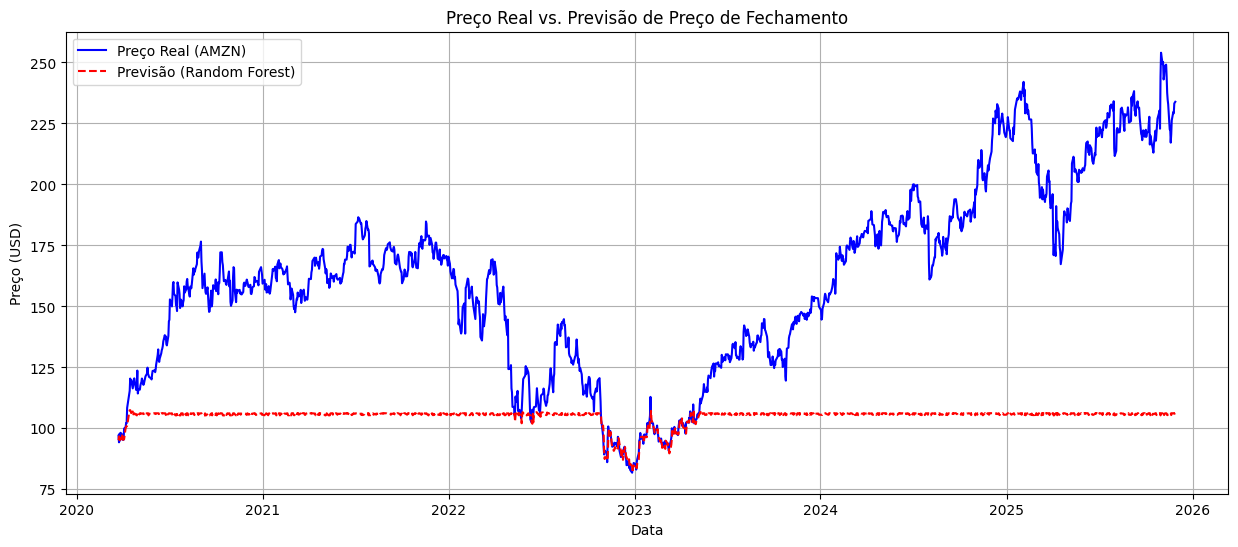

In [9]:
import matplotlib.pyplot as plt

# Criar um DataFrame para visualização Random Forest
results_df = y_test.to_frame(name='Actual Price')
results_df['Predicted Price (RF)'] = predictions_rf

plt.figure(figsize=(15, 6))
plt.plot(results_df.index, results_df['Actual Price'], label='Preço Real (AMZN)', color='blue')
plt.plot(results_df.index, results_df['Predicted Price (RF)'], label='Previsão (Random Forest)', color='red', linestyle='--')
plt.title('Preço Real vs. Previsão de Preço de Fechamento')
plt.xlabel('Data')
plt.ylabel('Preço (USD)')
plt.legend()
plt.grid(True)
plt.show()

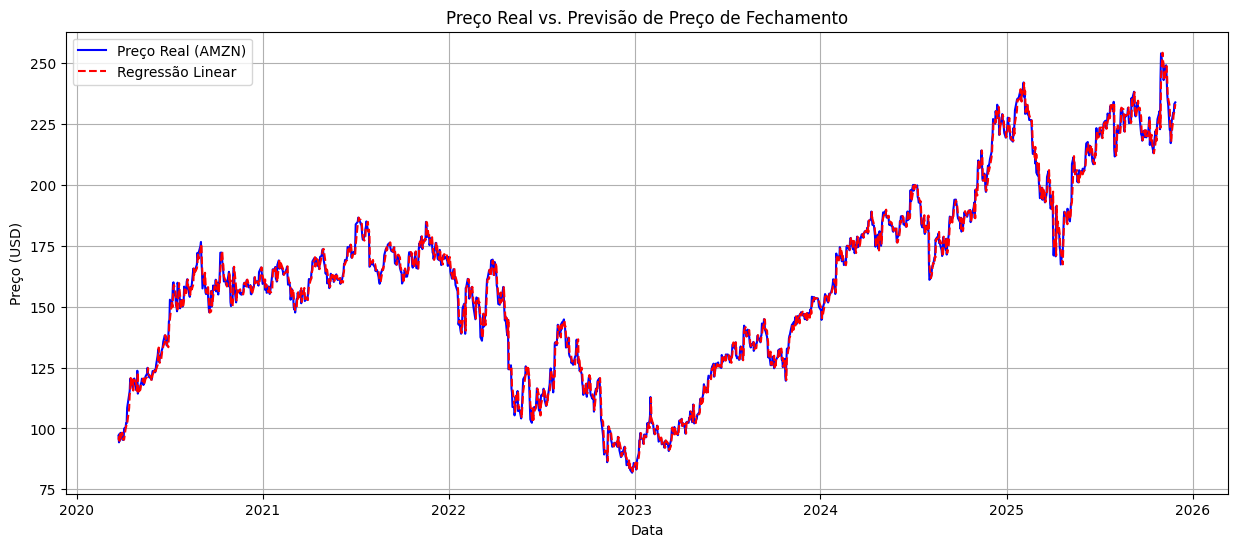

In [10]:
# Criar um DataFrame para visualização RL
results_df = y_test.to_frame(name='Actual Price')
results_df['Predicted Price (RF)'] = predictions_lr

plt.figure(figsize=(15, 6))
plt.plot(results_df.index, results_df['Actual Price'], label='Preço Real (AMZN)', color='blue')
plt.plot(results_df.index, results_df['Predicted Price (RF)'], label='Regressão Linear', color='red', linestyle='--')
plt.title('Preço Real vs. Previsão de Preço de Fechamento')
plt.xlabel('Data')
plt.ylabel('Preço (USD)')
plt.legend()
plt.grid(True)
plt.show()